## Categorical data

In [1]:
import pandas as pd
# pandas show all columns of table instead of restricted#
pd.set_option('display.max_columns', None)
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np
import math

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

from envirocar import correction as correct 
from envirocar import manipulation as manipulate
from envirocar import inspection as inspect

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

In [2]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])
# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=40) 

Understand the datatypes. Objects are usually categorical variables.

In [5]:
track_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10072 entries, 0 to 187
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              10072 non-null  object  
 1   time                            10072 non-null  object  
 2   geometry                        10072 non-null  geometry
 3   Engine Load.value               9251 non-null   float64 
 4   Engine Load.unit                9251 non-null   object  
 5   Calculated MAF.value            7313 non-null   float64 
 6   Calculated MAF.unit             7313 non-null   object  
 7   Speed.value                     10065 non-null  float64 
 8   Speed.unit                      10065 non-null  object  
 9   CO2.value                       8025 non-null   float64 
 10  CO2.unit                        8025 non-null   object  
 11  Intake Pressure.value           8566 non-null   float64 
 12  Intake Press

As here we are interested in categorical variables referring to the attributes of the sensor, we select the sensor variables.

In [6]:
sensorAttributes, sensor = inspect.get_sensor_columns(track_df)
sensorAttributes

,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer
0,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
1,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
2,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
3,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
4,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
...,...,...,...,...,...,...,...
183,car,2000,passat,5796666de4b086b281bfc0be,diesel,2011,VW
184,car,2000,passat,5796666de4b086b281bfc0be,diesel,2011,VW
185,car,2000,passat,5796666de4b086b281bfc0be,diesel,2011,VW
186,car,2000,passat,5796666de4b086b281bfc0be,diesel,2011,VW


### Inspect categories per variable

Inspect the categories per variable:

In [7]:
inspect.get_categories(sensorAttributes)

sensor.type ['car']
sensor.engineDisplacement [1699 1587 2000]
sensor.model ['A 170' 'V40' 'passat']
sensor.id ['559e22c2e4b07207d8977998' '564b916be4b0a3a81b856f28'
 '5796666de4b086b281bfc0be']
sensor.fuelType ['gasoline' 'diesel']
sensor.constructionYear [2004 2003 2011]
sensor.manufacturer ['Mercedes Benz' 'Volvo' 'VW']


Inspect distribution of each categorical variable:

<AxesSubplot:>

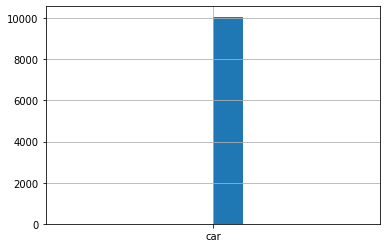

In [8]:
sensorAttributes['sensor.type'].hist()

<AxesSubplot:>

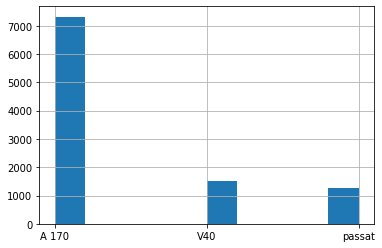

In [9]:
sensorAttributes['sensor.model'].hist()

<AxesSubplot:>

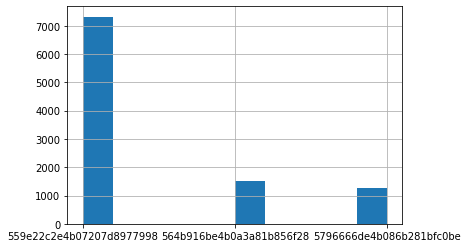

In [10]:
sensorAttributes['sensor.id'].hist()

<AxesSubplot:>

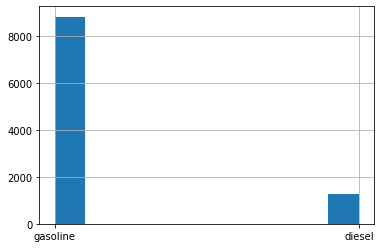

In [11]:
sensorAttributes['sensor.fuelType'].hist()

<AxesSubplot:>

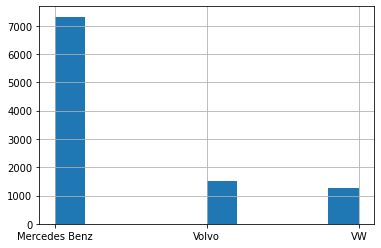

In [12]:
sensorAttributes['sensor.manufacturer'].hist()

### One Hot Encoding (Dummies)

In the case we want to conduct some analysis e.g. with machine learning, we may need to transform the categorical data to dummies (or do one-hot encoding)

In [13]:
manipulate.get_dummies_sensor(sensorAttributes)

,sensor.type_car,sensor.engineDisplacement_1587,sensor.engineDisplacement_1699,sensor.engineDisplacement_2000,sensor.model_A 170,sensor.model_V40,sensor.model_passat,sensor.id_559e22c2e4b07207d8977998,sensor.id_564b916be4b0a3a81b856f28,sensor.id_5796666de4b086b281bfc0be,sensor.fuelType_diesel,sensor.fuelType_gasoline,sensor.constructionYear_2003,sensor.constructionYear_2004,sensor.constructionYear_2011,sensor.manufacturer_Mercedes Benz,sensor.manufacturer_VW,sensor.manufacturer_Volvo
0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0
1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0
2,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0
3,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0
4,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0
184,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0
185,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0
186,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0
